# Prep for Challenge 3: Export btrack Example Dataset as TIFFs

## Why use btrack example dataset?
- Proven to work smoothly with btrack tracking
- Optimized size (~100 frames, ~50 cells/frame)
- Fast optimization (~1-2 minutes)
- No memory/performance issues

## Steps:
1. Load btrack example segmentation dataset
2. Export frames as TIFF files
3. Use these TIFFs for Challenge 3 tracking demo

In [16]:
# Step 1: Load btrack example segmentation dataset
import btrack
from btrack import datasets
from skimage.io import imread
from tifffile import imwrite
from pathlib import Path
import numpy as np

print("Loading btrack example segmentation dataset...\n")

# Get the example segmentation file
SEGMENTATION_FILE = datasets.example_segmentation_file()
print(f"Loading from: {SEGMENTATION_FILE}")

# Load the segmentation data
segmentation = imread(SEGMENTATION_FILE)

print(f"\n✓ Dataset loaded!")
print(f"  Shape: {segmentation.shape}")
print(f"  Dtype: {segmentation.dtype}")
print(f"  Number of frames: {len(segmentation)}")
print(f"  Frame dimensions: {segmentation.shape[1:3]}")
print(f"  Value range: {segmentation.min()} to {segmentation.max()}")

Loading btrack example segmentation dataset...

Loading from: /Users/user/Library/Caches/btrack-examples/examples/segmented.tif

✓ Dataset loaded!
  Shape: (500, 1200, 1600)
  Dtype: uint8
  Number of frames: 500
  Frame dimensions: (1200, 1600)
  Value range: 0 to 255


In [ ]:
# Step 2: Export as TIFF files for Challenge 3
from tqdm import tqdm

# Create output directory
OUTPUT_DIR = Path("./segmented_frames")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Exporting {len(segmentation)} frames to TIFF...")
print(f"Output directory: {OUTPUT_DIR}\n")

exported_files = []

for t in tqdm(range(len(segmentation)), desc="Exporting TIFFs"):
    # Create filename: frame_0000.tif
    filename = f"frame_{t:04d}.tif"
    filepath = OUTPUT_DIR / filename
    
    # Save as TIFF
    imwrite(filepath, segmentation[t], compression='zlib')
    exported_files.append(filepath)

print(f"\n✓ Export complete!")
print(f"  Total files exported: {len(exported_files)}")
print(f"  Output directory: {OUTPUT_DIR.absolute()}")
print(f"\nExample files:")
for f in exported_files[:3]:
    print(f"  - {f.name}")
if len(exported_files) > 3:
    print(f"  ... and {len(exported_files) - 3} more")

Exporting 500 frames to TIFF...
Output directory: btrack_example_tiffs



Exporting TIFFs: 100%|██████████| 500/500 [00:05<00:00, 94.63it/s] 


✓ Export complete!
  Total files exported: 500
  Output directory: /Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/notebooks/btrack_example_tiffs

Example files:
  - frame_0000.tif
  - frame_0001.tif
  - frame_0002.tif
  ... and 497 more


-------

# Prep for Challenge 1: Convert ND2 to TIFF Files


In [ ]:
# Solution: Load ND2 file and export frames as TIFF
import nd2
from pathlib import Path
from tifffile import imwrite
from tqdm import tqdm

# Configuration
ND2_FILE_PATH = "/Volumes/AMBY_SSD/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"
OUTPUT_DIR = Path("./raw_tiff_frames")
POSITION = 0  # Which position to extract
CHANNEL = 0   # Which channel to extract
NUM_FRAMES = 20  # How many frames to export

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Loading ND2 file: {ND2_FILE_PATH}")
print(f"Output directory: {OUTPUT_DIR}\n")

# Load ND2 file and export frames
with nd2.ND2File(ND2_FILE_PATH) as nd2_file:
    # Use dask array to avoid loading entire file into memory
    nd2_data = nd2_file.to_dask()
    
    print(f"ND2 file shape: {nd2_data.shape}")
    print(f"Extracting {NUM_FRAMES} frames from Position {POSITION}, Channel {CHANNEL}\n")
    
    for t in tqdm(range(NUM_FRAMES), desc="Exporting frames"):
        # Extract frame one at a time: [T, P, C, Y, X]
        frame = nd2_data[t, POSITION, CHANNEL, :, :].compute()
        
        # Save as TIFF
        filename = f"frame_{t:04d}.tif"
        filepath = OUTPUT_DIR / filename
        imwrite(filepath, frame, compression='zlib')

print(f"\n✓ Export complete!")
print(f"  Exported {NUM_FRAMES} TIFF files to {OUTPUT_DIR.absolute()}")


-------
# Challenge 1: Chamber Alignment

## Objective
Align raw microscopy images that have stage jitter/drift using the registration module.

## Task
1. Load raw ND2 data
2. Apply image registration to correct for stage drift
3. Visualize the before/after alignment
4. Compare aligned vs unaligned image sequences

## Expected Output
- Aligned image stack
- Side-by-side comparison showing improvement
- Overlay visualization demonstrating alignment quality

In [16]:
!pip install nd2reader


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Load TIFF files for Challenge 1
from pathlib import Path
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Path to TIFF files created in "Prep for Challenge 1"
TIFF_DIR = Path("./raw_tiff_frames")

print(f"Loading TIFF files from: {TIFF_DIR}")
print(f"Directory exists: {TIFF_DIR.exists()}\n")

# Load all TIFF files
tiff_files = sorted(TIFF_DIR.glob("frame_*.tif"))
print(f"Found {len(tiff_files)} TIFF files\n")

if len(tiff_files) == 0:
    print("⚠️  No TIFF files found!")
    print("   Please run 'Prep for Challenge 1' cell first to create the TIFF files.")
else:
    # Load all frames
    raw_images = []
    for tiff_file in tiff_files:
        frame = imread(tiff_file)
        raw_images.append(frame)
    
    raw_images = np.array(raw_images)
    
    print(f"✓ Loaded {len(raw_images)} frames")
    print(f"  Shape: {raw_images.shape}")
    print(f"  Dtype: {raw_images.dtype}")

Loading TIFF files from: raw_tiff_frames
Directory exists: True

Found 20 TIFF files

✓ Loaded 20 frames
  Shape: (20, 1040, 1392)
  Dtype: uint16


In [25]:
# Registration functions (complete implementation from tool - embedded in notebook)
from numba import jit
import numpy as np
from skimage import exposure
from tqdm import tqdm
from dataclasses import dataclass
from typing import Optional

@jit(nopython=True)
def ShiftedImage_2D_numba(Image, XShift, YShift):
    """Ultra-fast numba-compiled image shifting."""
    if XShift == 0 and YShift == 0:
        return Image.copy()

    h, w = Image.shape[:2]

    if Image.ndim == 3:
        result = np.zeros((h, w, Image.shape[2]), dtype=Image.dtype)
        channels = Image.shape[2]
    else:
        result = np.zeros((h, w), dtype=Image.dtype)
        channels = 1

    # Parallel pixel-wise shifting with bounds checking
    for i in range(h):
        for j in range(w):
            src_i = i - YShift
            src_j = j - XShift

            if 0 <= src_i < h and 0 <= src_j < w:
                if Image.ndim == 3:
                    for c in range(channels):
                        result[i, j, c] = Image[src_i, src_j, c]
                else:
                    result[i, j] = Image[src_i, src_j]
            else:
                # Edge padding: find nearest valid pixel
                nearest_i = max(0, min(h - 1, src_i))
                nearest_j = max(0, min(w - 1, src_j))

                if Image.ndim == 3:
                    for c in range(channels):
                        result[i, j, c] = Image[nearest_i, nearest_j, c]
                else:
                    result[i, j] = Image[nearest_i, nearest_j]

    return result

@jit(nopython=True)
def SAD(a, b):
    """Parallel-safe SAD using local accumulation."""
    flat_a = a.ravel()
    flat_b = b.ravel()
    n = len(flat_a)

    # Create thread-local storage
    num_threads = min(8, n // 1000)  # Limit threads for small arrays
    local_sums = np.zeros(num_threads, dtype=np.float64)

    for i in range(n):
        thread_id = i % num_threads
        local_sums[thread_id] += abs(float(flat_a[i]) - float(flat_b[i]))

    return np.sum(local_sums) / n

def alignment_MAE(Image_1, Image_2, depth_cap):
    """Tree Search Algorithm to find optimal alignment."""
    iterative_cap = 0
    Best_SAD = SAD(Image_1, Image_2)
    Best_Displacement = [0, 0]
    q = []
    visited_states = [[0, 0]]  # Add (0,0) displacement
    q.append(Best_Displacement)  # Append (0,0) displacement

    while iterative_cap != depth_cap and q:
        curr_state = q.pop(0)
        x = curr_state[0]
        y = curr_state[1]
        iterative_cap += 1
        movement_arr = [
            [x, y - 1],  # Up
            [x, y + 1],  # Down
            [x + 1, y],  # Left
            [x - 1, y],  # Right
            [x - 1, y - 1],  # Diagonal
            [x + 1, y + 1],  # Diagonal
            [x + 1, y - 1],  # Diagonal
            [x - 1, y + 1],  # Diagonal
        ]

        for move in movement_arr:
            if move not in visited_states:
                visited_states.append(move)  # Marked as Visited

                # Perform shift and calculate
                new_image = ShiftedImage_2D_numba(Image_2, move[0], move[1])
                cand_SAD = SAD(Image_1, new_image)
                if cand_SAD < Best_SAD:
                    Best_SAD = cand_SAD
                    Best_Displacement = move
                    q.append(move)

    return Best_Displacement, Best_SAD

@jit(nopython=True)
def compute_row_means_2d(img):
    """Custom row mean computation for 2D arrays."""
    rows, cols = img.shape
    row_means = np.empty(rows, dtype=np.float64)
    for i in range(rows):
        total = 0.0
        for j in range(cols):
            total += float(img[i, j])
        row_means[i] = total / cols
    return row_means

@jit(nopython=True)
def compute_row_means_3d(img):
    """Custom row mean computation for 3D arrays."""
    rows, cols, channels = img.shape
    row_means = np.empty(rows, dtype=np.float64)
    for i in range(rows):
        total = 0.0
        for j in range(cols):
            for k in range(channels):
                total += float(img[i, j, k])
        row_means[i] = total / (cols * channels)
    return row_means

@jit(nopython=True)
def compute_bottom_top_gradient(row_brightness):
    # Calculate gradient manually
    gradient = np.empty(len(row_brightness) - 1, dtype=np.float64)
    for i in range(len(gradient)):
        gradient[i] = row_brightness[i + 1] - row_brightness[i]

    # Suppress extreme values near edges
    height = row_brightness.shape[0]
    for i in range(len(gradient)):
        if (i <= 100 or i >= height - 100) and abs(gradient[i]) >= 150:
            gradient[i] = 0.0

    # Find top edge (maximum gradient in upper half)
    half_height = height // 2
    max_val = -np.inf
    top_edge = 0
    for i in range(min(half_height, len(gradient))):
        if gradient[i] > max_val:
            max_val = gradient[i]
            top_edge = i

    # Find bottom edge (minimum gradient in lower half)
    min_val = np.inf
    bottom_edge = half_height

    for i in range(half_height, len(gradient)):
        if gradient[i] < min_val:
            min_val = gradient[i]
            bottom_edge = i

    return top_edge, bottom_edge

def edge_detection_numba_fixed(img):
    """Numba-compatible vertical edge detection function."""
    # Compute row-wise brightness averages
    if img.ndim == 3:
        row_brightness = np.mean(img, axis=(1, 2))
    else:
        row_brightness = np.mean(img, axis=1)

    return compute_bottom_top_gradient(row_brightness)

@dataclass
class ImageRegistrationResult:
    registered_images: Optional[np.ndarray] = None
    offsets: Optional[np.ndarray] = None

def register_images(
    img_array,
    iteration_depth: int = 1000,
    m=False,
    verbose: bool = False,
    mcm: bool = False,
    return_images: bool = False,
):
    """
    Register images to remove stage jitter.
    
    Parameters:
    -----------
    img_array : numpy array
        Array of images to register
    iteration_depth : int
        Search depth for alignment algorithm
    mcm : bool
        Microfluidic chamber mode (disable X shifts)
    return_images : bool
        Whether to return registered images
    """

    scores = []
    image_offsets = [(0, 0)]  # Base is the reference, no transformation
    transformed_images = []

    if img_array.ndim != 3:
        print("Give a series of grayscale images. Shape: {}".format(img_array.shape))

    base = exposure.rescale_intensity(img_array[0])
    base_top, base_bottom = edge_detection_numba_fixed(base)

    if base.ndim == 3:
        base = base[:, :, 0]  # Reduce to the 2D

    iteration = 0

    for _frame in tqdm(img_array[1:]):
        iteration += 1

        template_image = exposure.rescale_intensity(_frame)  # Get rid of low exposure

        template_top, template_bottom = edge_detection_numba_fixed(template_image)

        if template_image.ndim == 3:
            template_image = template_image[:, :, 0]  # Reduce to the 2D

        displacement, score = alignment_MAE(base, template_image, iteration_depth)
        scores.append(score)

        if mcm:
            displacement[0] = 0

        y_shift = int(
            np.mean([(base_top - template_top), (base_bottom - template_bottom)])
        )
        image_offsets.append((displacement[0], y_shift))

        if return_images:
            shifted_image = ShiftedImage_2D_numba(
                template_image, displacement[0], y_shift
            )  # X,Y
            transformed_images.append(shifted_image)

    image_offsets = np.array(image_offsets)

    return ImageRegistrationResult(
        registered_images=transformed_images if return_images else None,
        offsets=image_offsets,
    )

print("✓ Complete registration functions loaded (with edge detection)")

✓ Complete registration functions loaded (with edge detection)


In [ ]:
# Perform image registration to remove stage jitter
print("Running image registration...")

# Convert to uint8 for registration (like the tool does)
images_uint8 = ((raw_images / 65535) * 255).astype(np.uint8)

# Get ONLY the offsets (don't return registered images)
registration_result = register_images(
    images_uint8,
    iteration_depth=1000,  # Search depth for alignment algorithm
    return_images=False    # Only get offsets, like the tool does
)

offsets = registration_result.offsets

print(f"\nRegistration complete!")
print(f"Computed {len(offsets)} offset pairs")

# Apply offsets to ORIGINAL uint16 images
aligned_images = []
for t in range(len(raw_images)):
    _x, _y = offsets[t]
    # Apply the shift to the original image
    shifted = ShiftedImage_2D_numba(raw_images[t], _x, _y)
    aligned_images.append(shifted)

aligned_images = np.array(aligned_images)

print(f"Aligned images shape: {aligned_images.shape}")
print(f"Aligned images dtype: {aligned_images.dtype}")
print(f"Value range: [{aligned_images.min()}, {aligned_images.max()}]")

# Display offset statistics
x_offsets = offsets[:, 0]
y_offsets = offsets[:, 1]
print(f"\nOffset statistics:")
print(f"X-offsets - Mean: {np.mean(x_offsets):.2f}, Std: {np.std(x_offsets):.2f}, Range: [{np.min(x_offsets)}, {np.max(x_offsets)}]")
print(f"Y-offsets - Mean: {np.mean(y_offsets):.2f}, Std: {np.std(y_offsets):.2f}, Range: [{np.min(y_offsets)}, {np.max(y_offsets)}]")

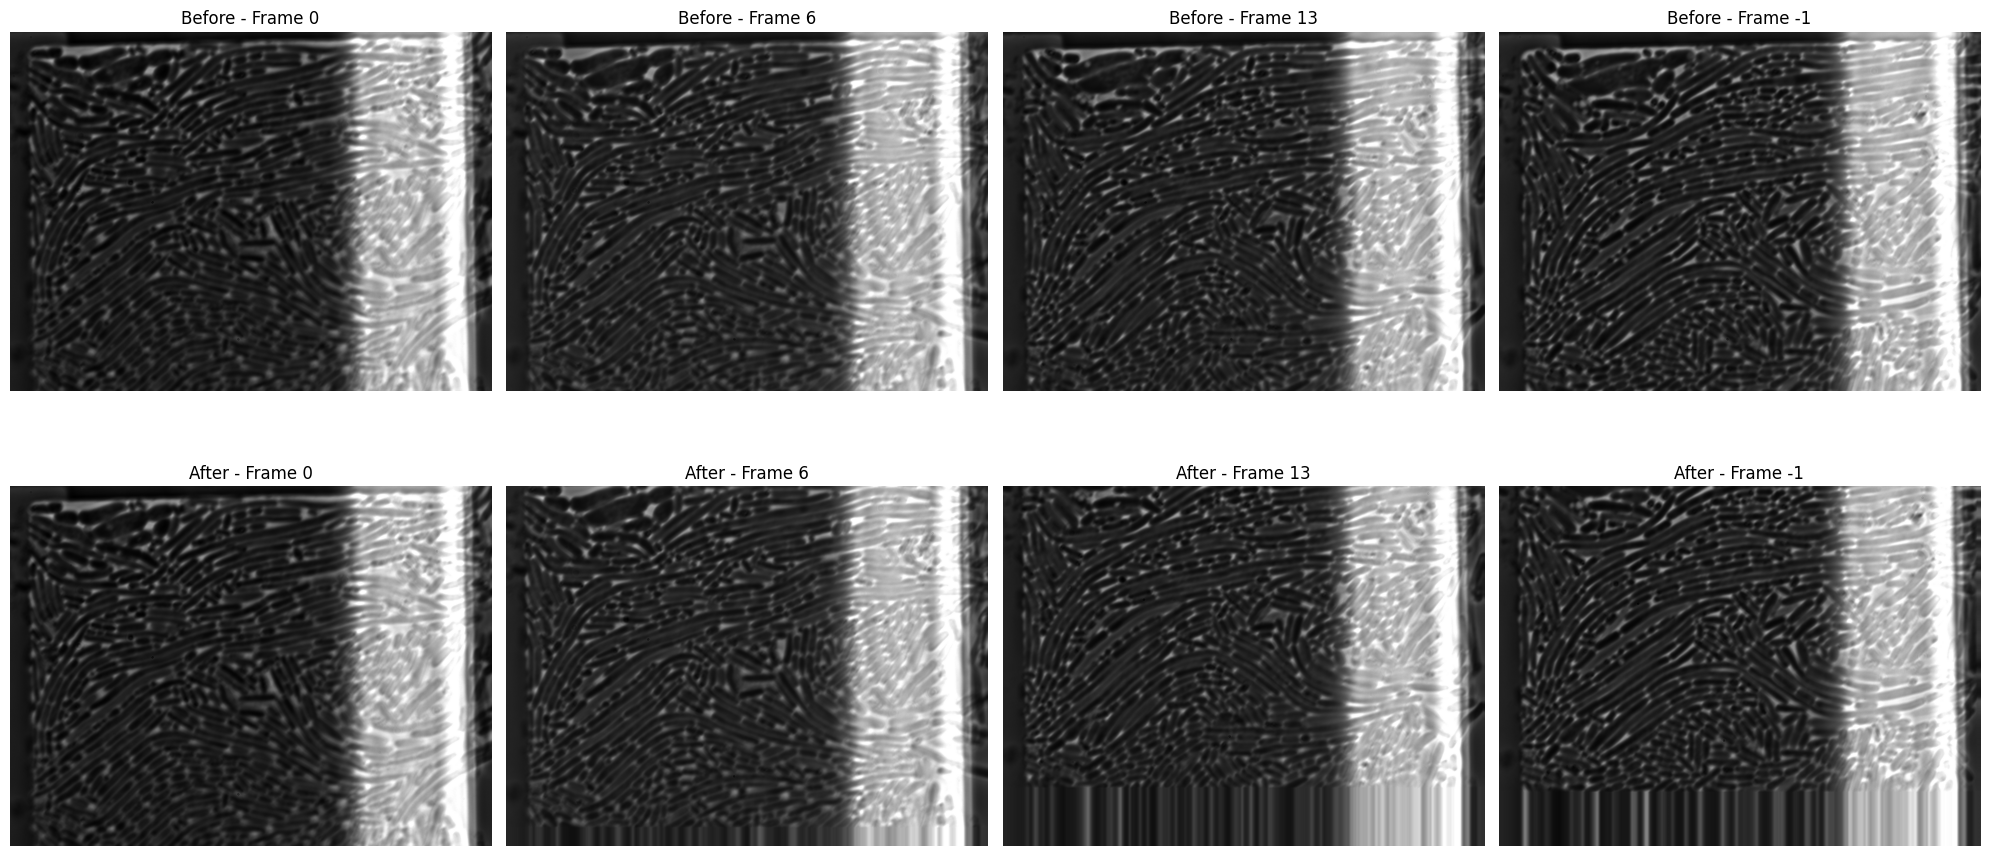

In [27]:
# Side-by-side comparison of before/after alignment for selected frames
frame_indices = [0, len(raw_images)//3, 2*len(raw_images)//3, -1]  # First, two middle, last

fig, axes = plt.subplots(2, len(frame_indices), figsize=(20, 10))

for i, idx in enumerate(frame_indices):
    # Before alignment
    axes[0, i].imshow(raw_images[idx], cmap='gray')
    axes[0, i].set_title(f'Before - Frame {idx}')
    axes[0, i].axis('off')

    # After alignment
    axes[1, i].imshow(aligned_images[idx], cmap='gray')
    axes[1, i].set_title(f'After - Frame {idx}')
    axes[1, i].axis('off')

# Row labels
axes[0, 0].set_ylabel('Raw (Unaligned)', fontsize=12, rotation=0, ha='right', va='center')
axes[1, 0].set_ylabel('Aligned', fontsize=12, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.savefig('chamber_alignment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Optional: Save aligned images for further analysis or create a video
import tifffile

# Save aligned images as TIFF stack
output_file = 'aligned_images.tif'
tifffile.imwrite(output_file, aligned_images.astype(np.uint16))
print(f"Saved aligned images to: {output_file}")

# Create a simple animation comparison (if desired)
# You can use matplotlib.animation or imageio to create GIFs
try:
    import imageio

    # Create GIF comparing before/after
    # Normalize for better visualization
    def normalize_frame(frame):
        return ((frame - frame.min()) / (frame.max() - frame.min()) * 255).astype(np.uint8)

    # Select subset of frames for GIF (every 2nd frame to keep file size manageable)
    step = 2
    frames_subset = range(0, len(raw_images), step)

    # Create side-by-side comparison frames
    comparison_frames = []
    for idx in frames_subset:
        # Normalize
        raw_norm = normalize_frame(raw_images[idx])
        aligned_norm = normalize_frame(aligned_images[idx])

        # Stack horizontally
        combined = np.hstack([raw_norm, aligned_norm])
        comparison_frames.append(combined)

    # Save as GIF
    imageio.mimsave('alignment_comparison.gif', comparison_frames, duration=0.1)
    print("Saved comparison GIF to: alignment_comparison.gif")

except ImportError:
    print("imageio not installed. Skipping GIF creation.")
    print("Install with: pip install imageio")

print("\nChallenge 1 Complete!")

Saved aligned images to: aligned_images.tif
Saved comparison GIF to: alignment_comparison.gif

Challenge 1 Complete!



-----
# Challenge 3: Cell Tracking

## Objective
Track individual cells across 10 frames from segmented microscopy images.


## Task
1. Load segmented images (10 frames)
2. Localize cells in each frame using region properties
3. Run btrack to link cells across frames
5. Visualize the results in napari

## Expected Output
- Track statistics (number of tracks, average track length)
- Visualization of cell tracks overlaid on images

## Importing btrack and loading example datasets

In [1]:
# Load the btrack example TIFF files for Challenge 3
import btrack
from pathlib import Path
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

# Path to btrack example frames folder
SEGMENTED_FRAMES_DIR = Path("./segmented_frames")

print(f"Loading btrack example frames from: {SEGMENTED_FRAMES_DIR}")
print(f"Directory exists: {SEGMENTED_FRAMES_DIR.exists()}\n")

# List all TIFF files
tiff_files = sorted(SEGMENTED_FRAMES_DIR.glob("frame_*.tif"))
print(f"Found {len(tiff_files)} TIFF files")

if len(tiff_files) == 0:
    print("\n⚠️  No TIFF files found!")
    print("   Please run the 'Prep for Challenge 3' cells first to export the btrack example dataset.")

Loading btrack example frames from: segmented_frames
Directory exists: True

Found 500 TIFF files


We can automatically download some example data to play with:

In [2]:
# Load all segmented frames into a numpy array
print("Loading segmented frames into memory...\n")

# Configure number of frames to load (adjust based on available memory)
NUM_FRAMES_TO_LOAD = 100  # Change this: 50 for low memory, 100 for medium, 500 for full dataset

segmented_stack = []
for i, tiff_file in enumerate(tiff_files):
    # Stop if we've loaded enough frames
    if i >= NUM_FRAMES_TO_LOAD:
        break
    
    frame = imread(tiff_file)
    
    # Check if this is a colored RGB image (from our visualization) or grayscale labeled
    if frame.ndim == 3:  # RGB colored version
        print(f"⚠️  {tiff_file.name} is RGB colored - need grayscale labeled masks for tracking")
        print("   Please re-run the segmentation export WITHOUT the colored visualization")
        break
    else:  # Grayscale labeled segmentation
        segmented_stack.append(frame)
        if len(segmented_stack) <= 3 or len(segmented_stack) == NUM_FRAMES_TO_LOAD:
            num_cells = frame.max()
            print(f"  ✓ Loaded {tiff_file.name}: {num_cells} cells")

segmented_stack = np.array(segmented_stack)

print(f"\n✓ Loaded {len(segmented_stack)} frames (out of {len(tiff_files)} available)")
print(f"  Stack shape: {segmented_stack.shape}")
print(f"  Data type: {segmented_stack.dtype}")
print(f"  Value range: {segmented_stack.min()} to {segmented_stack.max()}")
print(f"\n💡 To load more/fewer frames, change NUM_FRAMES_TO_LOAD above")

Loading segmented frames into memory...

  ✓ Loaded frame_0000.tif: 255 cells
  ✓ Loaded frame_0001.tif: 255 cells
  ✓ Loaded frame_0002.tif: 255 cells
  ✓ Loaded frame_0099.tif: 255 cells

✓ Loaded 100 frames (out of 500 available)
  Stack shape: (100, 1200, 1600)
  Data type: uint8
  Value range: 0 to 255

💡 To load more/fewer frames, change NUM_FRAMES_TO_LOAD above


## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [3]:
# Create a montage of segmented frames for visualization
from skimage.util import montage
import matplotlib.pyplot as plt

# Select frames to display in montage (evenly spaced)
grid_shape = (4, 5)  # 4 rows x 5 columns = 20 frames
total_frames_to_show = grid_shape[0] * grid_shape[1]

# Get evenly spaced frame indices
if len(segmented_stack) >= total_frames_to_show:
    frame_indices = np.linspace(0, len(segmented_stack)-1, total_frames_to_show, dtype=int)
else:
    frame_indices = np.arange(len(segmented_stack))

selected_frames = segmented_stack[frame_indices]

print(f"Creating montage with {len(selected_frames)} frames...")
print(f"Frame indices: {frame_indices.tolist()[:5]} ... {frame_indices.tolist()[-2:]}")

# Create montage
seq = montage(
    selected_frames, 
    grid_shape=grid_shape, 
    padding_width=10, 
    fill=0,
)

# Display the montage
fig, ax = plt.subplots(1, figsize=(16, 13))
ax.imshow(seq, cmap='nipy_spectral')  # Use colorful colormap to see different cells
ax.set_title(f'Segmented Frames Montage ({len(selected_frames)} frames)', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()

# Save for presentation
plt.savefig('segmentation_montage.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Montage saved to: segmentation_montage.png")

plt.show()

Using segmented_stack from above: (100, 1200, 1600)


### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [5]:
# Extract cell features from segmented frames for tracking
FEATURES = [
    "area", 
    "major_axis_length", 
    "minor_axis_length", 
    "orientation", 
    "solidity"
]

print("Extracting objects from segmented frames...")
print(f"Features to extract: {FEATURES}\n")

objects = btrack.utils.segmentation_to_objects(
    segmented_stack, 
    properties=tuple(FEATURES), 
    num_workers=4,  # parallelise this
)

print(f"✓ Extracted {len(objects)} objects from {len(segmented_stack)} frames")
print(f"\nSample object:")
print(objects[0])

[INFO][2025/11/06 04:52:51 PM] Localizing objects from segmentation...
[INFO][2025/11/06 04:52:51 PM] Processing using 4 workers.


Extracting objects from segmented frames...
Features to extract: ['area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity']



progress: 100%|██████████| 100/100 [00:03<00:00, 30.33it/s]
[INFO][2025/11/06 04:52:55 PM] Objects are of type: <class 'dict'>
[INFO][2025/11/06 04:52:55 PM] ...Found 7281 objects in 100 frames.


✓ Extracted 7281 objects from 100 frames

Sample object:
{'ID': 0, 'x': 517.5736568457539, 'y': 9.072790294627383, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 577.0, 'major_axis_length': 33.26060270196957, 'minor_axis_length': 22.856213196295688, 'orientation': 1.4557077137732317, 'solidity': 0.9681208053691275}


We can also inspect each returned object to determine it's properties:

## Running the tracking

In [6]:
# Run btrack tracking on the segmented frames
from btrack import datasets

print("Initializing btrack tracker...\n")

# Get config file for cell tracking
CONFIG_FILE = datasets.cell_config()

# Initialize tracker and run tracking
with btrack.BayesianTracker() as tracker:

    # Configure the tracker using cell config
    tracker.configure(CONFIG_FILE)
    tracker.max_search_radius = 100  # Increased for bacterial cells
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    tracker.features = FEATURES

    # Append the objects to be tracked
    tracker.append(objects)

    # Set the tracking volume based on image dimensions
    h, w = segmented_stack.shape[1:3]
    tracker.volume = ((0, w), (0, h))
    
    print(f"Tracking volume: ({w} x {h})")
    print(f"Max search radius: {tracker.max_search_radius}")
    print(f"Number of objects: {len(objects)}\n")

    # Track them (in interactive mode)
    print("Running tracking algorithm...")
    tracker.track(step_size=100)

    # Generate hypotheses and run the global optimizer
    print("Optimizing tracks...")
    tracker.optimize()

    # Get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # Store the tracks
    tracks = tracker.tracks
    
    # Store the configuration
    cfg = tracker.configuration

print(f"\n✓ Tracking complete!")
print(f"  Total tracks found: {len(tracks)}")

# Track statistics
track_lengths = [len(track.t) for track in tracks]
print(f"  Average track length: {np.mean(track_lengths):.2f} frames")
print(f"  Longest track: {max(track_lengths)} frames")
print(f"  Shortest track: {min(track_lengths)} frames")

[INFO][2025/11/06 04:53:21 PM] Loaded btrack: /Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/.venv/lib/python3.10/site-packages/btrack/libs/libtracker.dylib
[INFO][2025/11/06 04:53:21 PM] Starting BayesianTracker session
[INFO][2025/11/06 04:53:21 PM] Loading configuration file: /Users/user/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2025/11/06 04:53:22 PM] Objects are of type: <class 'list'>
[INFO][2025/11/06 04:53:22 PM] Starting tracking... 
[INFO][2025/11/06 04:53:22 PM] Update using: ['MOTION', 'VISUAL']


Initializing btrack tracker...

Tracking volume: (1600 x 1200)
Max search radius: 100.0
Number of objects: 7281

Running tracking algorithm...


[INFO][2025/11/06 04:53:22 PM] Tracking objects in frames 0 to 99 (of 100)...
[INFO][2025/11/06 04:53:22 PM]  - Timing (Bayesian updates: 0.34ms, Linking: 0.29ms)
[INFO][2025/11/06 04:53:22 PM]  - Probabilities (Link: 1.00000, Lost: 0.98159)
[INFO][2025/11/06 04:53:22 PM] SUCCESS.
[INFO][2025/11/06 04:53:22 PM]  - Found 109 tracks in 100 frames (in 0.0s)
[INFO][2025/11/06 04:53:22 PM]  - Inserted 11 dummy objects to fill tracking gaps
[INFO][2025/11/06 04:53:22 PM] Loading hypothesis model: cell_hypothesis
[INFO][2025/11/06 04:53:22 PM] Calculating hypotheses (relax: True)...
[INFO][2025/11/06 04:53:22 PM] Setting up constraints matrix for global optimisation...
[INFO][2025/11/06 04:53:22 PM] Optimizing...
[INFO][2025/11/06 04:53:22 PM] Optimization complete. (Solution: optimal)
[INFO][2025/11/06 04:53:22 PM]  - Fates.FALSE_POSITIVE: 5 (of 109)
[INFO][2025/11/06 04:53:22 PM]  - Fates.LINK: 12 (of 20)
[INFO][2025/11/06 04:53:22 PM]  - Fates.DIVIDE: 3 (of 3)
[INFO][2025/11/06 04:53:22 PM

Optimizing tracks...
GLPK Integer Optimizer 5.0
436 rows, 350 columns, 485 non-zeros
350 integer variables, all of which are binary
Preprocessing...
218 rows, 350 columns, 485 non-zeros
350 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 218
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
218 rows, 350 columns, 485 non-zeros
*     0: obj =   3.480863621e+02 inf =   0.000e+00 (28)
*    25: obj =   1.301425675e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    25: mip =     not found yet >=              -inf        (1; 0)
+    25: >>>>>   1.301425675e+02 >=   1.301425675e+02   0.0% (1; 0)
+    25: mip =   1.301425675e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND

✓ Tracking complete!
  Total tracks found: 97
  Average track

## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [7]:
cell = tracks[1]
cell

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,solidity,major_axis_length,minor_axis_length,area
0,2,0,657.399225,4.426357,0.0,2,2,5,0,False,1.534682,0.973585,28.650424,11.908765,258.0
1,2,1,657.715481,4.029289,0.0,2,2,5,0,False,1.557410,0.983539,28.759037,11.040913,239.0
2,2,2,656.904167,4.125000,0.0,2,2,5,0,False,1.530523,0.979592,28.651696,11.037060,240.0
3,2,3,656.217993,4.667820,0.0,2,2,5,0,False,1.543631,0.989726,31.094621,12.138052,289.0
4,2,4,653.219298,6.710526,0.0,2,2,5,0,False,-1.478267,0.966102,26.502698,17.054772,342.0
5,2,5,654.336420,7.256173,0.0,2,2,5,0,False,1.537582,0.975904,23.073315,18.407481,324.0
6,2,6,653.078014,6.971631,0.0,2,2,5,0,False,1.287062,0.975779,20.781504,18.031229,282.0
7,2,7,653.767790,6.632959,0.0,2,2,5,0,False,1.248538,0.960432,20.536610,17.685798,267.0
8,2,8,651.496124,6.116279,0.0,2,2,5,0,False,1.426393,0.962687,21.267710,16.412172,258.0
9,2,9,650.666667,8.757106,0.0,2,2,5,0,False,-1.434154,0.962687,23.116262,21.986416,387.0


## Visualising the data with napari

Finally, we an inspect the entire tracking output using *napari*:

In [ ]:
!pip install napari

In [8]:
# Visualize tracking results in napari
import napari

viewer = napari.Viewer()

# Add the segmented images as labels layer (shows colored cells with boundaries)
viewer.add_image(
    segmented_stack, 
    name="Segmented Cells"
)

# Add the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
)

print("✓ Napari viewer opened with segmentation and tracks!")
print("  - Toggle layers on/off to see segmentation vs tracks")
print("  - Use the timeline slider to see tracking over time")

napari.run()

✓ Napari viewer opened with segmentation and tracks!
  - Toggle layers on/off to see segmentation vs tracks
  - Use the timeline slider to see tracking over time


In [7]:
# Export tracking animation as GIF from napari
import napari
import imageio
from tqdm import tqdm
import numpy as np
import os

print("Creating tracking animation GIF...\n")

# Create a new napari viewer for GIF export
viewer = napari.Viewer()

# Add the segmented images as grayscale image (not colored labels)
viewer.add_image(
    segmented_stack, 
    name="Segmented Cells",
)

# Add the track data
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
    visible=True,
    tail_width=2,
    tail_length=30
)

# Configure viewer settings for better visualization
viewer.dims.ndisplay = 2

# Capture frames for GIF
frames = []
num_frames = len(segmented_stack)

# Subsample frames to keep GIF size reasonable (every 5th frame)
frame_step = 5
frame_indices = range(0, num_frames, frame_step)

print(f"Capturing {len(frame_indices)} frames (subsampling every {frame_step} frames)...")

for t in tqdm(frame_indices, desc="Capturing frames"):
    # Set time point
    viewer.dims.current_step = (t, 0, 0)
    
    # Give napari a moment to update
    viewer.window.qt_viewer.update()
    
    # Capture screenshot
    frame = viewer.screenshot(canvas_only=True, flash=False)
    frames.append(frame)

# Close the viewer
viewer.close()

# Save as GIF
output_file = 'tracking_animation.gif'
print(f"\nSaving GIF to {output_file}...")
imageio.mimsave(output_file, frames, fps=10, loop=0)

print(f"\n✓ GIF export complete!")
print(f"  Output file: {output_file}")
print(f"  Total frames: {len(frames)}")
print(f"  Frame rate: 10 fps")
print(f"  File size: {os.path.getsize(output_file) / (1024*1024):.2f} MB")

Creating tracking animation GIF...

Capturing 20 frames (subsampling every 5 frames)...


Capturing frames:   0%|          | 0/20 [00:00<?, ?it/s]/var/folders/zr/wpzp7_1j4j92c55gk680nbkh0000gn/T/ipykernel_78725/1835242426.py:49: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.7.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.update()
Capturing frames: 100%|██████████| 20/20 [00:00<00:00, 35.41it/s]



Saving GIF to tracking_animation.gif...

✓ GIF export complete!
  Output file: tracking_animation.gif
  Total frames: 20
  Frame rate: 10 fps
  File size: 0.35 MB


### Export Tracking Animation as GIF

This cell creates an animated GIF showing the cell tracking over time. The GIF will show:
- Segmented cells (colored labels)
- Track trajectories with tails
- Animation through all time points

**Note:** This will subsample frames (every 5th frame) to keep the file size manageable.

-----

# Challenge 4: Bacterial Lineage Trees



## Task
1. Load lineage data from CSV file
2. Build a directed graph showing parent→child relationships
3. Identify separate lineage trees (connected components)
4. Visualize the top 5 largest lineages with color-coded morphology
5. Calculate statistics: lifespan, division frequency, morphology distribution



In [ ]:
# Step 1: Load Data and Build Lineage Graph

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the data
csv_path = '/Applications/Oliveira Lab Projects/nd2-analyzer/PARTAKER/partaker/notebooks/lineage_data.csv'
df = pd.read_csv(csv_path)

print(f"Loaded {len(df)} cells")
print(f"Frames: {df['start_frame'].min()} to {df['end_frame'].max()}")
print(f"\nFirst few rows:")
print(df.head())

# Build a directed graph (parent → child)
G = nx.DiGraph()

# Add all cells as nodes
for _, row in df.iterrows():
    G.add_node(row['track_id'], **row.to_dict())

# Add parent-child edges
for _, row in df.iterrows():
    if row['parent_id'] != 0:  # Skip founder cells
        G.add_edge(row['parent_id'], row['track_id'])

print(f"\nGraph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Find separate lineage trees
lineages = list(nx.weakly_connected_components(G))
print(f"Found {len(lineages)} separate lineage trees")

# Find the biggest lineages
lineage_sizes = [(len(lineage), lineage) for lineage in lineages]
lineage_sizes.sort(reverse=True)

print(f"\nLargest lineages:")
for i, (size, _) in enumerate(lineage_sizes[:5]):
    print(f"  Lineage {i+1}: {size} cells")

In [ ]:
# Step 2: Visualize Lineage Trees with Statistics

# Morphology colors - using ORIGINAL class names
COLORS = {
    'elongated': '#4285F4',  # Blue
    'healthy': '#34A853',        # Green
    'divided': '#FBBC04',     # Orange
    'curved': '#9C27B0'      # Purple
}

def hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    '''
    Create hierarchical tree layout - founder at top, descendants below.
    Ensures proper spacing between nodes.
    '''
    def h_recur(G, root, width, vert_gap, vert_loc, xcenter, pos, parent, parsed):
        if root not in parsed:
            parsed.append(root)
            if pos is None:
                pos = {root:(xcenter, vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            neighbors = list(G.neighbors(root))
            if parent is not None and parent in neighbors:
                neighbors.remove(parent)
            if len(neighbors) != 0:
                dx = width/len(neighbors) 
                nextx = xcenter - width/2 - dx/2
                for neighbor in neighbors:
                    nextx += dx
                    pos = h_recur(G, neighbor, width=dx, vert_gap=vert_gap, 
                                 vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                 parent=root, parsed=parsed)
        return pos
    return h_recur(G, root, width, vert_gap, vert_loc, xcenter, {}, None, [])

# Pick the TOP 5 largest lineages
top_lineages = [lineage for _, lineage in lineage_sizes[:5]]

fig, axes = plt.subplots(2, 3, figsize=(20, 16), facecolor='white')
axes = axes.flatten()

for idx, lineage_cells in enumerate(top_lineages):
    ax = axes[idx]
    
    # Create subgraph for this lineage
    subgraph = G.subgraph(lineage_cells)
    
    # Find the founder (root) cell
    founders = [n for n in subgraph.nodes() if subgraph.in_degree(n) == 0]
    founder = founders[0] if founders else list(subgraph.nodes())[0]
    
    # Create hierarchical layout - VERY LONG vertical gaps for uniform long arrows
    num_nodes = len(subgraph.nodes())
    pos = hierarchy_pos(subgraph, founder, width=num_nodes*2.0, vert_gap=2.0)
    
    # Get node colors based on morphology
    node_colors = [COLORS.get(subgraph.nodes[n].get('morphology_class', 'healthy'), '#999999') 
                   for n in subgraph.nodes()]
    
    # Draw the tree
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                          node_size=600, edgecolors='black', linewidths=2, ax=ax)
    nx.draw_networkx_edges(subgraph, pos, arrows=True, arrowsize=18, 
                          width=2.5, edge_color='black', ax=ax)
    nx.draw_networkx_labels(subgraph, pos, font_size=9, 
                           font_weight='bold', font_color='white', ax=ax)
    
    # Calculate statistics
    morphology_counts = {}
    all_frames = []
    
    for node in subgraph.nodes():
        morph = subgraph.nodes[node].get('morphology_class', 'unknown')
        morphology_counts[morph] = morphology_counts.get(morph, 0) + 1
        all_frames.append(subgraph.nodes[node].get('start_frame', 0))
        all_frames.append(subgraph.nodes[node].get('end_frame', 0))
    
    lifespan = max(all_frames) - min(all_frames)
    num_divisions = subgraph.number_of_edges()
    division_freq = num_divisions / lifespan if lifespan > 0 else 0
    
    # Title with stats
    title = f"Lineage {idx+1} (Root Parent: {founder})\n"
    title += f"{len(subgraph)} cells, {lifespan} frames\n"
    title += f"Divisions: {num_divisions} ({division_freq:.2f}/frame)"
    ax.set_title(title, fontsize=11, fontweight='bold', pad=5)
    ax.axis('off')
    ax.margins(0.1)
   

# Hide the 6th subplot
axes[5].axis('off')

# Add legend with ORIGINAL class names
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['elongated'], edgecolor='black', linewidth=2, label='Elongated'),
    Patch(facecolor=COLORS['healthy'], edgecolor='black', linewidth=2, label='healthy'),
    Patch(facecolor=COLORS['divided'], edgecolor='black', linewidth=2, label='divided'),
    Patch(facecolor=COLORS['curved'], edgecolor='black', linewidth=2, label='curved')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
          fontsize=12, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.savefig('lineage_trees.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n{'='*40}")
print("✓ Visualizations saved to lineage_trees.png")